In [84]:
import xarray
import matplotlib.pyplot as mp
import cartopy
import numpy
import glob
import gdal
import matplotlib.colors
import geopandas
import shapely
import cmocean
import pandas
import joblib

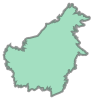

In [58]:
states = geopandas.read_file('/beegfs/DATA/pritchard/blangenb/NATURAL_EARTH_DATA/ne_10m_admin_1_states_provinces')
states_indo = states[states['admin']=='Indonesia']

# extract Kalimantan (Indonesian Borneo)
kali_indices = ['Kalimantan' in i for i in states_indo['name']]
states_indo_kalimantan = states_indo[kali_indices]

# also extract Malaysian Borneo
states_malay = states[states['admin']=='Malaysia']
states_malay_borneo = states_malay[[n in ['Sabah','Sarawak'] for n in states_malay['name']]]
states_brunei = states[states['admin']=='Brunei']

borneo_gdf = pandas.concat([states_indo_kalimantan, states_malay_borneo, states_brunei])
borneo_gdf_union = borneo_gdf.geometry.unary_union
borneo_main_geom = borneo_gdf_union.geoms[15]
list(borneo_gdf_union.geoms)[15]

In [2]:
#filename = '/Users/baird/Dropbox/_data_observations/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4-10.2018-05-31T17-55-21ZN.hdf'
file_dir = '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/'

In [141]:
#file_list = sorted(glob.glob(file_dir+'/*.hdf'))
file_list = sorted(numpy.load('./borneo_land_mass_intersection_files_ALL.npy'))

In [9]:
# ===== open file, pull out specific data set
gdal_file = gdal.Open(file_list[0])
gdal_subdatasets = gdal_file.GetSubDatasets()
gdal_clf_ds = gdal.Open(gdal_subdatasets[31][0]) # cloud fraction
gdal_tbc_ds = gdal.Open(gdal_subdatasets[35][0]) # total backscatter

In [10]:
gdal_clf_data = gdal_clf_ds.ReadAsArray()
gdal_tbc_data = gdal_tbc_ds.ReadAsArray()

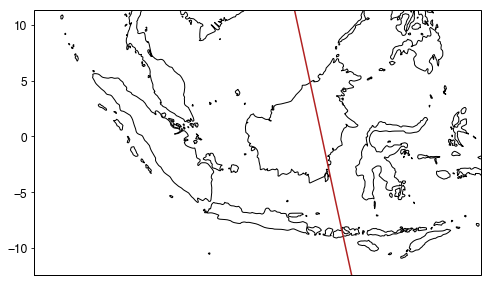

In [13]:
ds = xarray.open_dataset(file_list[0])

lat = ds['Latitude'].isel(fakeDim3=0).values
lon = ds['Longitude'].isel(fakeDim5=0).values


#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

ax.plot(lon,lat,c='firebrick')

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

plot multiple at once

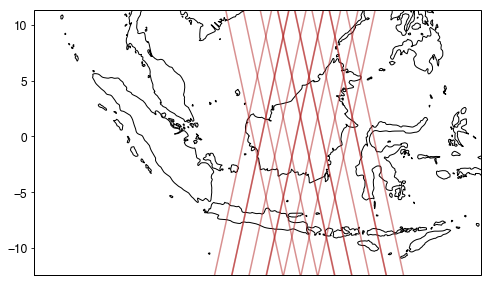

In [33]:
ds = xarray.open_dataset(file_list[0])

#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

# get the distinct ones
for file in file_list[:20]:
    ds = xarray.open_dataset(file)
    lat = ds['Latitude'].isel(fakeDim3=0).values
    lon = ds['Longitude'].isel(fakeDim5=0).values
    ax.plot(lon,lat,c='firebrick',alpha=0.5)
    ds.close()

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

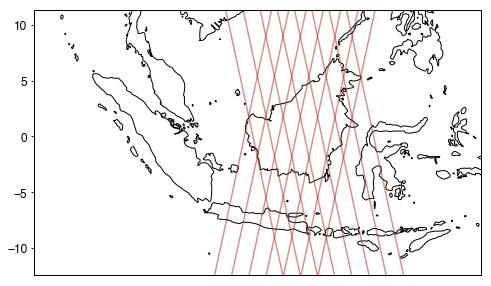

In [31]:
ds = xarray.open_dataset(file_list[0])

#####
fontsize=12
map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([90,130,-12,11])
#ax.set_extent([50,180,-70,70])
ax.coastlines(resolution='50m')

# get the distinct ones
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,17,18]:
#for file in file_list[0,1,2,3,4,5]:
    file = file_list[i]
    ds = xarray.open_dataset(file)
    lat = ds['Latitude'].isel(fakeDim3=0).values
    lon = ds['Longitude'].isel(fakeDim5=0).values
    ax.plot(lon,lat,c='firebrick',alpha=0.5)
    ds.close()

ax.set_yticks([-10,-5,0,5,10])
ax.tick_params(labelsize=fontsize)

In [34]:
distinct_track_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,17,18]

In [75]:
track_geom_list = []
file_intersect_list = []

f_base=0
base_track_filename = file_list[distinct_track_indices[f_base]]
base_track_ds = xarray.open_dataset(base_track_filename)
lat = base_track_ds['Latitude'].isel(fakeDim3=0).values
lon = base_track_ds['Longitude'].isel(fakeDim5=0).values
base_track_ds.close()
base_track_geom = shapely.geometry.LineString(zip(lon,lat))
base_track_geom_buffer = base_track_geom.buffer(1)
track_geom_list.append(base_track_geom)
file_intersect_list.append(base_track_filename)

# buffer must contain ENTIRE cropped 
for f in range(50):
    
    if f==f_base:
        continue

    ds = xarray.open_dataset(file_list[f])
    lat = ds['Latitude'].isel(fakeDim3=0).values
    lon = ds['Longitude'].isel(fakeDim5=0).values
    ds.close()

    track_geom_temporary = shapely.geometry.LineString(zip(lon,lat))
    track_geom_borneo = track_geom_temporary.intersection(borneo_main_geom)
    
    #if track_geom_borneo.intersects(base_track_geom_buffer):
    if base_track_geom_buffer.contains(track_geom_borneo):
        track_geom_list.append(track_geom_temporary)
        file_intersect_list.append(file_list[f])

file_intersect_list = numpy.array(file_intersect_list)
#numpy.save('borneo_land_mass_intersections.npy', file_intersect_list)

In [76]:
track_geom_list

# Parallelize this

In [204]:
# define function to search whether the paths intersect
# faster to have borneo_main_geom already defined

f_base_index=0

base_track_filename = file_list[distinct_track_indices[f_base_index]]
base_track_ds = xarray.open_dataset(base_track_filename)
lat = base_track_ds['Latitude'].isel(fakeDim3=0).values
lon = base_track_ds['Longitude'].isel(fakeDim5=0).values
base_track_ds.close()
base_track_geom = shapely.geometry.LineString(zip(lon,lat))
base_track_geom_buffer = base_track_geom.buffer(1)

geometry_of_interest = borneo_main_geom

def are_the_tracks_mostly_the_same(f_index, f_base_index=0):
    
    track_geom_list = []
    file_intersect_list = []
    
    if f_index==f_base_index:
        pass
    
    else:
        ds = xarray.open_dataset(file_list[f_index])
        lat = ds['Latitude'].isel(fakeDim3=0).values
        lon = ds['Longitude'].isel(fakeDim5=0).values
        ds.close()

        track_geom_temporary = shapely.geometry.LineString(zip(lon,lat))
        track_geom_cropped = track_geom_temporary.intersection(geometry_of_interest)

        #if track_geom_borneo.intersects(base_track_geom_buffer):
        if base_track_geom_buffer.contains(track_geom_cropped):
            track_geom_list.append(track_geom_temporary)
            file_intersect_list.append(file_list[f_index])

    return file_intersect_list#, track_geom_list

In [ ]:
joblib_result_list = []

for fbi in [17,18]:#distinct_track_indices:
    
    print(fbi)

    f_base_index=fbi

    base_track_filename = file_list[f_base_index]
    base_track_ds = xarray.open_dataset(base_track_filename)
    lat = base_track_ds['Latitude'].isel(fakeDim3=0).values
    lon = base_track_ds['Longitude'].isel(fakeDim5=0).values
    base_track_ds.close()
    base_track_geom = shapely.geometry.LineString(zip(lon,lat))
    base_track_geom_buffer = base_track_geom.buffer(1)

    geometry_of_interest = borneo_main_geom
    
    joblib_result = [[base_track_filename]] + joblib.Parallel(n_jobs=4, verbose=1)\
    (joblib.delayed(are_the_tracks_mostly_the_same)(f, f_base_index=fbi) for f in range(file_list.__len__()))
    
    joblib_result_list.append([item for sublist in joblib_result for item in sublist])

17


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.3s


In [224]:
joblib_result_list_copy = joblib_result_list.copy()

In [226]:
a = [i.__len__() for i in joblib_result_list_copy]
sum(a)

3236

In [228]:
file_list.__len__()

3591

In [229]:
(3591-3236)

355

In [202]:
flatten_result = [item for sublist in joblib_result for item in sublist]
#numpy.save('borneo_land_mass_intersection_files_ALL.npy', flatten_result)

In [203]:
flatten_result

['/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2006-06-13T05-41-22ZD.hdf',
 '/beegfs/DATA/pritchard/blangenb/CALIPSO_DATA/CAL_LID_L2_05kmCPro-Standard-V4-10.2006-06-29T05-41-23ZD.hdf']